In [24]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

import sklearn


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import seaborn as sns

import pydot



In [25]:
data_train = pd.read_csv('/content/full_eng.csv')
data_train.head()

Unnamed: 0                                               Text  label
0           0                                          Next part      0
1           1                 Iii8mllllllm\nMdxfvb8o90lplppi0005      0
2           2  🤣🤣😂😂🤣🤣🤣😂osm vedio ....keep it up...make more v...      0
3           3  What the fuck was this? I respect shwetabh and...      0
4           4  Concerned authorities should bring arundathi R...      0

In [26]:
data_test = pd.read_csv('/content/test.csv')

In [27]:
data_test.drop(['ID','Sub-task B'], axis=1, inplace=True)

In [28]:
NAG_test = data_test[(data_test['Sub-task A']=='NAG')]
OAG_test= data_test[(data_test['Sub-task A']=='CAG')]
CAG_test = data_test[(data_test['Sub-task A']=='OAG')]

In [29]:
import warnings as wrn
wrn.filterwarnings('ignore')

NAG_test["Sub-task A"] = 0 
#negatives_test["Sentiment"] = 0

OAG_test["Sub-task A"] = 1
#positives_test["Sentiment"] = 2

CAG_test["Sub-task A"] = 2
#neutrals_test["Sentiment"] = 1

NAG_test.head()

Text  Sub-task A
0        U deserve more subscribers. U really great.           0
1                                     Nice video....           0
2  sorry if i bother somebody.. iam a defence asp...           0
3  Joker was amazing....it was not glamorised !.....           0
4                                          Nice baro           0

In [30]:
data_test = pd.concat([NAG_test,
                  OAG_test,
                  CAG_test
                 ],axis=0)

data_test.reset_index(inplace=True)

In [31]:

data_test = data_test.rename(columns = {'Sub-task A': 'label'}, inplace = False)

In [32]:
X = data_train.Text.astype(str)
Y = data_train.label
#le = LabelEncoder()
#Y = le.fit_transform(Y)
#Y = Y.reshape(-1,1)

In [33]:
X_train,X_valid,y_train,y_valid = train_test_split(X,Y,test_size=0.15)

In [34]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

[[5488, 86, 11, 9]]


In [35]:

x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(data_test['Text'].tolist()) )


In [36]:

x_train = pad_sequences(x_train, padding='post', maxlen=150)
x_valid = pad_sequences(x_valid, padding='post', maxlen=150)
x_test = pad_sequences(x_test, padding='post', maxlen=150)

In [37]:
train_labels = np.asarray(y_train )
valid_labels = np.asarray( y_valid)

test_labels = np.asarray(data_test['label'].tolist())

In [38]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [39]:

max_features =50000
embedding_dim =16
sequence_length = 150

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
                               



model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.Accuracy()])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 16)           800016    
_________________________________________________________________
dropout_3 (Dropout)          (None, 150, 16)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 16)           2112      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2400)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1229312   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                

In [40]:
epochs = 30
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/30
7/7 [==============================] - 9s 811ms/step - loss: 4.0331 - accuracy: 0.0000e+00 - val_loss: 2.9530 - val_accuracy: 0.0000e+00
Epoch 2/30
7/7 [==============================] - 5s 700ms/step - loss: 2.6918 - accuracy: 0.0000e+00 - val_loss: 1.9697 - val_accuracy: 0.0000e+00
Epoch 3/30
7/7 [==============================] - 5s 702ms/step - loss: 1.8107 - accuracy: 0.0040 - val_loss: 1.3959 - val_accuracy: 0.0000e+00
Epoch 4/30
7/7 [==============================] - 5s 692ms/step - loss: 1.3213 - accuracy: 0.2253 - val_loss: 1.1603 - val_accuracy: 0.4038
Epoch 5/30
7/7 [==============================] - 5s 693ms/step - loss: 1.1544 - accuracy: 0.3861 - val_loss: 1.2015 - val_accuracy: 0.4054
Epoch 6/30
7/7 [==============================] - 5s 701ms/step - loss: 1.2533 - accuracy: 0.3999 - val_loss: 1.4745 - val_accuracy: 0.4054
Epoch 7/30
7/7 [==============================] - 5s 706ms/step - loss: 1.5761 - accuracy: 0.4140 - val_loss: 1.9546 - val_accuracy: 0.4054


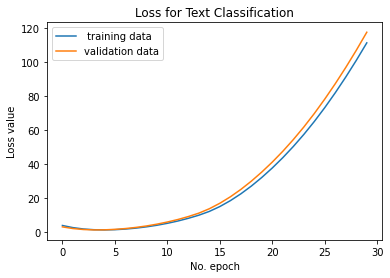

In [41]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [42]:

x_test  = np.array( tokenizer.texts_to_sequences(data_test['Text'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=150)


In [43]:
print("Generate predictions for all samples")
predictions = model.predict(x_test)

Generate predictions for all samples


In [44]:

data_test['pred']= predictions

In [45]:

labels = [0,1,2]
    
print(classification_report(data_test['label'].tolist(),data_test['pred'].tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77       836
           1       0.14      0.42      0.21       117
           2       0.00      0.00      0.00       113

    accuracy                           0.60      1066
   macro avg       0.33      0.38      0.33      1066
weighted avg       0.67      0.60      0.63      1066

